# Fitting Example Workbook

In this workbook we will go through the process of getting a source position and size from a catalogue, using that information to download a GLEAM image, and then fitting a morphological 2D Gaussian model to that image. This workbook aims to be a template for implementing this process for supernova remnants (SNRs) and HII regions in the Galactic plane (hereon GP). 


## The Model

In astronomy we are interested in the modelling the morphological distribution of a sources brightness. Most sources in radio astronmy are point sources, however some sources are extended, like SNRs and HII regions. A simple morphological model of an extended source would be a single 2D Gaussian $G(x,y)$:

$$
\begin{equation}
    G(x,y) = G_0 \exp{\left(-\left(a(x - x_0)^2 + 2b(x - x_0)(y - y_0) +c(y - y_0)^2 \right) \right)  }
\end{equation}
$$
$x_0$ and $y_0$ are the cartesian positions of the centre of the 2D Gaussian; $G_0$ is the amplitude, and the coefficients $a$, #b$ and $c$ are given by:

$$
\begin{align}
    a &= \frac{\cos^2{\theta_p}}{2\sigma^2_x} + \frac{\sin^2{\theta_p}}{2\sigma^2_y}\\
    b &= -\frac{\sin{2\theta_p}}{4\sigma^2_x} + \frac{\sin{2\theta_p}}{4\sigma^2_y}\\
    c &= \frac{\sin^2{\theta_p}}{2\sigma^2_x} + \frac{\cos^2{\theta_p}}{2\sigma^2_y}
\end{align}
$$
$\sigma_x$ and $\sigma_y$ are the Gaussian widths, and $\theta_p$ is the relative rotation of the Gaussian with respect to the $y$ axis (this definition is not standard in all cases).

As you will see source morphology can be quite complex, and a single Gaussian is often not good enough to capture the complexity. To account for this we can construct a model of the source by summining up $N_\textrm{gauss}$. Each Gaussian has six model parameters, for a total of $6N_\textrm{gauss}$ parameters for $N_\textrm{gauss}$ components. The resulting model is represented by:

$$
\begin{equation}
    I_\textrm{Source}(x,y;\hat{\theta}) = \sum^{N_\textrm{gauss}}_{i=0} G(x,y;\hat{\theta}_i)
\end{equation}
$$
$\hat{\theta}_i$ is the parameter vector for the ith Gaussian. 

These models are not physically motivated, that is, there is no physics that goes into the choice of model, other types of modelling functions such as shapelets also exist. However they are useful, Gaussian functions are well known standard functions, that have many uses particularly in physics. 

There are several motivations for constructing these types of models: these models are useful in calibrating radio interferometers; these models can be used in simulations to test our understanding of instruments, and what we expect to see for particualr observations. These are to name a few. 

Radio sources in addition to having brightness vary as a function of spatial extent, also have varying brightness as a function of frequency. Typically this is modelled using a power law, where $I \propto \nu^\alpha$ where $\nu$ is the frequency, and $\alpha$ is the spectral index. For extra-galactic radio sources this has a typical value of $-0.7$, and is related to synchrotron emission of relativistic electrons (we won't go into details here).

## The Method

Now that we have covered some of the basic pieces of material, next we will go over the method. The goal here is to take coordinates for a known SNR SN1006 (famous historical SNR look this one up), use a web API to download an MWA image from the GLEAM survey, take this image and perform peak detection and then fit multi-component Gaussian models to the image. 



### Importing modules.


In [1]:
import sys,os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))

import warnings
warnings.filterwarnings("ignore")

# Scipy stuff:
import scipy.optimize as opt

# Astropy stuff:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy import wcs
from astropy.io import fits
from astropy.io.votable import parse_single_table
from astropy.table import Table,Column,vstack
from astropy.io.votable import writeto as writetoVO
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from scipy import ndimage, misc


# Image processing packages:
from skimage.feature import blob_dog
from skimage.feature import blob_log

# Array module.
import numpy as np

# Module for fitting SNRs
from snrfit import NGaussian2D,SNR_Gauss_fit,determine_peaks_bkg
import snrfit

# For downlaoding images.
import gleam_client

Next we want to load in the catalogue which contains the position information for the SNRs. We do this using the `astropy` module, specifically the `Table` method. This can take a file object and read it as a table. Specifically we are loading in a `.fits` file, which is a flexible file format used for astronomy purposes. This format is used for both images, image cubes, and astronomy catalogue. Once the `Table` object is created we can 

In [2]:
# Parent directory.
parent_path = '../'

# Catalogue filename.
cat_filename = 'Green-167MHz-filtered-dec+30.fits'

# Opening fits table.
cat = fits.open(parent_path + 'data/' + cat_filename)

# Creating table object.
t_SNR = Table(cat[1].data)

# SNR ID's
SNR_IDs = np.array(t_SNR['recno']).astype('int')

# Getting the RA and Dec. # These may be different for different catalogues.
RA_vec = np.array(t_SNR['_RAJ2000'])
DEC_vec = np.array(t_SNR['_DEJ2000'])
SI_vec = np.array(t_SNR['Sp-Index']) # Spectral index vector


Printing the first 5 entries of the catalogue.

In [3]:
t_SNR[:5]

_RAJ2000,_DEJ2000,SNR,RAJ2000,DEJ2000,MajDiam,MinDiam,u_MinDiam,type,S_167MHz,u_S_167MHz,Sp-Index,u_Sp-Index,Names,recno
float64,float64,str11,str8,str6,float64,float64,str1,str2,float64,str1,float64,str2,str26,int32
272.2292,-27.05,G004.2-03.5,18 08 55,-27 03,28.0,28.0,,S,9.365265537559045,?,0.6,?,,9
270.5417,-24.9,G005.4-01.2,18 02 10,-24 54,35.0,35.0,,C?,50.06390827662627,?,0.2,?,Milne 56,13
268.7292,-23.0833,G006.1+01.2,17 54 55,-23 05,30.0,26.0,,F,6.84297652252258,?,0.3,?,,17
270.125,-23.4333,G006.4-00.1,18 00 30,-23 26,48.0,48.0,,C,758.5836155602144,,0.5,0.,W28,18
266.2917,-21.3667,G006.4+04.0,17 45 10,-21 22,31.0,31.0,,S,2.6598476616404763,?,0.4,?,,19


We don't need the whole catalogue, we only want the position information for SN1006. However, being able to read and index a catalgue using `astropy` is important. SNR SN1006 also has the name G327.6+14.6 which is is the SNRs position in Galactic longitute and latidude coordinates, which is a common naming scheme for these objects. We can use the name to look for the SNR in the table.

We also grab information about the angular extent of the object. This is useful, since the max image size we can get is 5 degrees. Some SNRs are close to this size. 

In [4]:
t_SN1006 = t_SNR[t_SNR['SNR'] == 'G327.6+14.6']

RA_SN1006 = np.float(RA_vec[t_SNR['SNR'] == 'G327.6+14.6'])
DEC_SN1006 = np.float(DEC_vec[t_SNR['SNR'] == 'G327.6+14.6'])

## Looping through each SNR. This may take sometime. 
Major = np.float(t_SNR['MajDiam'][t_SNR['SNR'] == 'G327.6+14.6']) #[arcmin]
Minor = np.float(t_SNR['MinDiam'][t_SNR['SNR'] == 'G327.6+14.6']) #[arcmin]

# Calculating the max angular size of the ith SNR image.
ang_size = 2*Major/60 # [Degrees].

print('RA : %s, DEC : %s' % (RA_SN1006,DEC_SN1006))
print('Major = %s [arcmin], Minor = %s [arcmin]' % (Major,Minor))
print('Angular size = %s [degrees]' % ang_size)

RA : 225.7083, DEC : -41.9333
Major = 30.0 [arcmin], Minor = 30.0 [arcmin]
Angular size = 1.0 [degrees]


### Downloading the image

Now that we have information about the source location, and image size, we can download the image from the GLEAM vo server. We do this by calling the `gleam_client` API, which sends a download request to the vo server. We pass the RA the DEC, the angular size, and the frequency range we want (there are only select frequency ranges you can choose from). We also provide a filename for the image. This filename should be meaningful, generally it should contain information about the source image, such as location, and frequency of the image.

In [5]:
%%capture

# Get SNR image from GLEAM using gleam_client.
freq_range = '170-231'

filename = 'RA%5.2f_DEC%5.2f_%sMHz.fits' % (RA_SN1006,DEC_SN1006,freq_range)

# For now download to the current working directory, but you can change this to whatever you like. Typically I like to have this separate from the main directory. 
download_dir = '../data/'

gleam_client.vo_get(RA_SN1006, DEC_SN1006, ang_size, freq=[freq_range], 
            proj_opt='SIN', download_dir=download_dir,file_name_func=filename)


### Loading in the image

Once the image is downloaded we need to load it into python, we again use `astropy`.

In [ ]:
warnings.filterwarnings("ignore")
with fits.open(download_dir+filename) as hdul:
    #hdul.info()
    header = hdul[0].header
    img_arr = hdul[0].data#[0,0,:,:]




The `WCS` is the world-coordinate-system, and defines how the spherical celestial coordinate system maps onto a cartesian grid. This information is contained in the `header` of the image `fits` file, and we can create a `wcs` object using `astropy` and the image header.

In [ ]:
w = WCS(header).celestial

### Plotting the image.

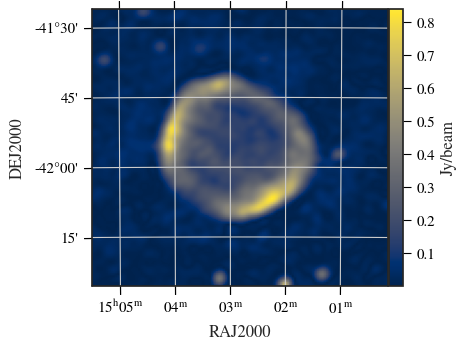

In [ ]:

snrfit.astro_plot_2D(img_arr, w, figsize=(7.5,6),scale=0.6)

### Creating a cartesian coordinate system.

To simplify the fitting process, because our images are smaller than $10\,\deg$ we can use the small angle approximation and assume that they're flat. This means we can perform our fits on a 2D surface, not the surface of a sphere. To do this we need to define a cartesian coordinate system, which has coordinates defined by the number of pixels. All the fitting will be done in this space, and the fit parameters converted back into celestial coordinates. 

In [ ]:
X = np.shape(img_arr)[0]
Y = np.shape(img_arr)[1]
print('Image shape (%s,%s)' % (X,Y))

# Defining the pixel grids.
x_pix = np.arange(X)
y_pix = np.arange(Y)
xx_pix, yy_pix = np.meshgrid(x_pix,y_pix)

# This is the pixel scale in degrees.
dx = np.abs(header['CD1_1']) #pixel scale in degrees [deg]

print('dx = %5.3e [deg]' % dx)

Image shape (129,129)
dx = 7.697e-03 [deg]


In the next step we calculate the image island. This masks all the data outside a certain radius from the centre of the SNR. We only want to fit the data relevant to the SNR, since we know how large the SNRs are we can use their size and position to masks all pixels outside of the SNR. The masked pixels are useful for calculating the image statistics, that is the rms, and the background. These are required for fitting, and estimating fitting errors. 

In [ ]:
# Getting the corresponding pixel coordinates for the image centre.
x_cent,y_cent = w.wcs_world2pix(RA_SN1006,DEC_SN1006,1)
print('Image pixel center = (%5.3f, %5.3f)' % (x_cent,y_cent))

# The RA and DEC arrays, can use to determine angular mask.
RA_arr, DEC_arr = w.wcs_pix2world(xx_pix + 1, yy_pix + 1, 1)
print('Determined the RA and DEC for the entire pixel grid.')

# Calculating the angular distance from the image centre to each pixel.
theta_dist = np.degrees(snrfit.great_circle_dist(np.radians(DEC_SN1006),
                    np.radians(DEC_arr),np.radians(RA_SN1006),np.radians(RA_arr)))
print('Calculated the angular distance from each pixel to the image centre.')

# Temporary index array. Used for masking the image. Size padded.
theta_ind_arr_ge = theta_dist >= 0.5*Major/60 + 7.5*dx

img_bkg,rms = snrfit.calc_img_bkg_rms(img_arr,mask_arr=theta_ind_arr_ge)

Image pixel center = (64.667, 64.667)
Determined the RA and DEC for the entire pixel grid.
Calculated the angular distance from each pixel to the image centre.
bkg = 0.016, rms = 0.035


Plotting the masked array, and calculating the new image array.

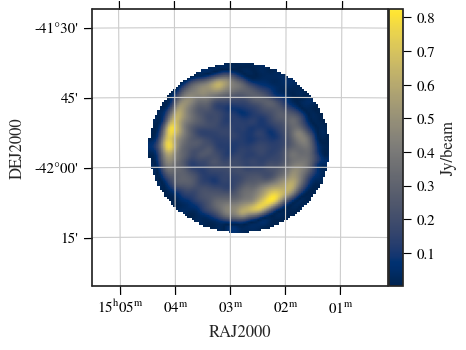

In [ ]:
img_nu = np.ones(img_arr.shape)*img_arr - img_bkg
img_nu[theta_ind_arr_ge] = np.nan

snrfit.astro_plot_2D(img_nu, w, figsize=(7.5,6),scale=0.6)

## Peak Detection

Peak detection is an important part in the modelling process. In this section we utilise the python package `skimage` which contains several peak detection methods, specifically we will be using the most accurate on `blob_log`. There are other methods such as `blob_dog` and `blob_doh`. Although hilariously named, the method names do stand for something significant. `blob_log` stands for "Laplacian of Gaussian". I'll explain the `blob_dog` method which stands for "Difference of Gaussians", which is an approximatin for the `blob_log` method.

The `blob_dog` method convolves the input image with a series of Gaussian with increasing standard deviations. The range (minimum to maximum sigma) and the number of Gaussians are tuneable parameters. It then calculates the difference between each blurred image, stacking these in a cube. Blobs or peak detections are local minima across each pixel which are determined by some threshold and overlap parameters; these are also tuneable. 

In the next section we go through an example, where I have set some standard parameters for calculating the peaks. First we need some information from the image header, specifically the image point spread function (PSF). The PSF is the resolution of the image, and itself is approximated by a Gaussian. It has parameters such as Major ($a$), and Minor ($b$) size, as well as position angle. We need to know this information because the smallest blob we can detect in the image is determined by the PSF. The PSF is convolved with the image. 

We can relate the PSF to the standard deviation of a Gaussian through $a = 2\sqrt{2\log{2}} \sigma$. Unlike $\sigma$ the Major axis is a diameter measurment, and not a radial measurement.

In [ ]:
a_psf = header['BMAJ'] #[deg]
b_psf = header['BMIN'] #[deg]
PA_psf = header['BPA'] #[deg]

# Easier than having lots of keywords arguments.
peak_constants = (a_psf,Major,dx,rms)

# Creating new coord object. 
coord_log_nu = snrfit.determine_peaks_bkg(img_nu,peak_constants,maj_fac=1,num_sigma=20,
            thresh_fac=0.5,overlap=1,log_cond=False)

Min sigma =  2.042 [pix]
Maximum sigma = 27.587
Performing peak detection with 1.073e-02 threshold.
Detected an initial 20 peaks.


### Plot the peaks

You should be able to tell by eye what features the peaks line up with. If it's not exact don't worry, the peak centres are tuneable parameters in the fitting process.

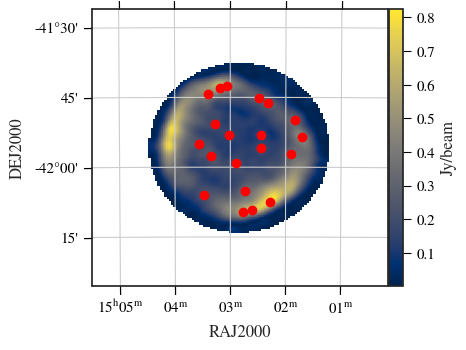

In [ ]:
snrfit.astro_plot_2D(img_nu, w, figsize=(7.5,6),scatter_points=coord_log_nu,scale=0.6)

## Fitting the data

In this section we will use the package `scipy` and the fitting method `curve_fit`, these are called by the functon `SNR_Gauss_fit`. Essentially, `curve_fit` takes a set of input data, a model function with $N$ parameters, and a set of guess parameters and fits the data. `SNR_Gauss_fit` also determines sensible bounds of the fit parameters to reduce the fitting parameters space. The method `curve_fit` uses is an iterative non-linear least squares method. The more Gaussians the longer the fit requires. I have found reasonable fitting up $\sim45$ Gaussians, you can probably do higher, but that is with my computer which is rather powerful. Generally if the parameters guesses are good, the fit time is minimal. 

In [ ]:
data = img_nu[theta_ind_arr_ge == False]
xx = xx_pix[theta_ind_arr_ge == False]
yy = yy_pix[theta_ind_arr_ge == False]

maj_min = (Major,Minor)

Here we are creating an array of guess parameters for the fitting. 

In [ ]:
# Parameter list is formatted like:
# p = [amplitude,x0,y0,sigx,sigy,theta_PA]

# Number of Gaussians is equal to the number of peaks. 
N_gauss = len(coord_log_nu)
N_params = 6 # 2D Gaussian parameters.

# The guess parameter array.
pguess = np.zeros((N_gauss,N_params))

# This is where we make our intellegent guess based on the peak positions,
# blob sizes and image pixel values.
# Assigning the row values for each column.
pguess[:,0] = coord_log_nu[:,3] # Amplitude
pguess[:,1] = coord_log_nu[:,1] # x0
pguess[:,2] = coord_log_nu[:,0] # y0

pguess[:,3] = coord_log_nu[:,2] # sigx
pguess[:,4] = coord_log_nu[:,2] # sigy

### Performing the fit.

In [ ]:

#constants = [2*Major,2*Minor,dx,a_psf,a_psf,0]
constants = [Major,Minor,dx,a_psf,a_psf,0]

popt,perr = SNR_Gauss_fit(xx,yy,data,coord_log_nu,constants,maj_frac=0.5)

2.042350888813898 2.042350888813898


### Testing our fit quality.

`popt` is the output fitted parameters and `perr` is the covariance matrix corresponding to the fit, where the diagonals are the errors on each of the parameters. We can test our fit quality by comparing the model image to the actual image, specifically by calculating the residual image. Our model is denoted by the function `N2DGaussian` from the `snrfit` module. 

In [ ]:

# Calculating the model image. 
zz = NGaussian2D((xx_pix,yy_pix),popt.ravel(),fit=False).reshape(X, Y)
 
# Printing the Gaussian sizes.
p_sigx = popt[:,3]
p_sigy = popt[:,4]

print(p_sigx[:5],np.max(p_sigx),np.min(p_sigx))
print(p_sigy[:5],np.max(p_sigy),np.min(p_sigy))


# Calculating the residual image.
resid_img = img_nu - zz

[5.14323258 2.26691934 2.1202407  6.31929527 9.51931034] 15.287630407643812 2.120240697129179
[4.58226371 5.69920105 7.54078604 2.82927769 3.0079359 ] 13.20322008577453 2.5223100501996063


### Plotting the model image, the data image, and the residual image. 

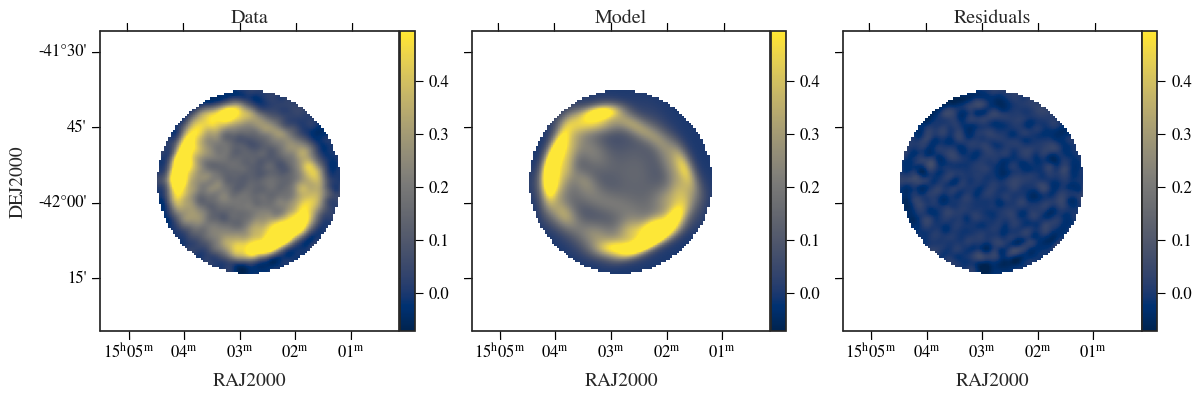

In [ ]:

zz[theta_ind_arr_ge] = np.nan
snrfit.point_plot(zz,img_nu,resid_img,w,scale=0.75)

Plotting the residual histogram, should be Gaussian like, if we have done a good job with the fit, the width should be close to the image rms.

rms = 2.146e-02 [Jy/beam]
residual std = 2.131e-02 [Jy/beam]


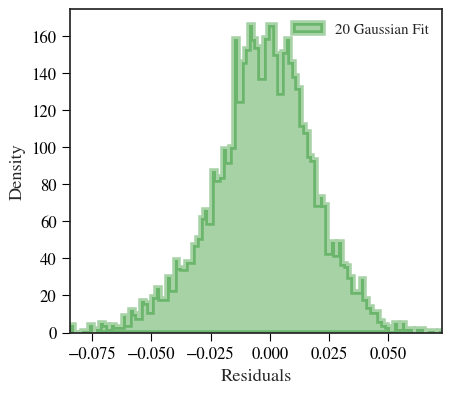

In [ ]:
print('rms = %5.3e [Jy/beam]' % rms)
print('residual std = %5.3e [Jy/beam]' % np.std(resid_img[theta_ind_arr_ge == False]))
snrfit.hist_residual_plot(resid_img[theta_ind_arr_ge == False],bins=100,N_peaks=len(coord_log_nu),scale=0.6)

### How many Gaussians is the correct number to model?

This is a good question, and the truth is there isn't always going to be an obvious answer. As you may have noticed when determining how many peaks to fit, you can change the number of peaks found by altering the parameters, this also leads to the question of what parameters are optimal? Again there is no good answer, the best you can do is make sensible choices using information that you already have about the source and the image. Image noise, source size, and resolution will be the biggest determining factors of how many Gaussians you can and should fit to a source.

Fitting too many Gaussians is called over fitting, and this often leads to fitting non-physical behaviour such as noise. This happens because the fitting process tries to minimise the residuals. In an ideal scenario our model should subtract all the intensity/signal from the source and leave behind just noise. The histogram above is a good representation of this, we should expect the residuals to be noise like, noise is typically modelled by a normal distribution. If you were to take all the pixels from a part of the image that has no sources, you should expect to see a normal distribution like the one above. It is still possible to overfit the data when you reach this regime, as such there are method which can compare two or more models with differing fit parameters, and residuals, to see which is a better representation of the data.

One popular method is the Bayesian Information Criterion (BIC):

$$
\begin{equation}
    \rm{BIC} = \chi^2 + k \log{N}
\end{equation}
$$

$\chi^2$ is the typical $\chi^2$ definition, $k$ is the number of model parameters, which is $6N_\textrm{gauss}$ for our Gaussian models, and $N$ is the number of data points. By calculating the BIC for different models, you can compare their values. Typically the model with the lowest BIC is a better representation of the data. This is a useful metric because it not only takes into consideration the quality of the fit $\chi^2$ but how many parameters it has $k$. Therefore it is sensitive to overfitting.

This method can be used with models of differing number of Gaussian components to compare which best represents the data, however this is computationally time consuming when the number of sources required to be fit is large, and the number of components required to be fit ranges from $10$ and above. As a good rule of thumb, for this type of data, you shouldn't need more than $50$ components to fit a large source (several degrees across). If you do there are other methods you can employ to reduce the number of components, with the loss of small scale information (there is always a trade off).   

For now this discussion serves as a reminder that sometimes less is more, you don't need a lot of peaks to get a good fit for a source. For this source $20$ is probably too much, but is at the boundary of overfitting.


### Calculating the $\chi^2$.

In [ ]:
chisqd = snrfit.Fit_quality(img_nu,popt.ravel(),xx_pix,yy_pix,rms)#,reduced_cond=True)

Npix = (len(img_nu[np.isnan(img_nu) == False]))

print('N_pix = %s' % Npix)
print('Chisqd = %5.3f' % chisqd)
print('Reduced Chisqd = %5.3f' % (chisqd/(Npix-np.size(popt))))

N_pix = 5026
Chisqd = 5053.244
Reduced Chisqd = 1.030


## Writing the Model to an Astropy FITS Table

Once we've found a good fit to the source we can write the model out to a FITS table using `astropy`. First we need to convert all the model parameters from pixel coordinates to celestial coordinates, that is in terms of degrees. Fortunately for you I figured this out a while, and this can be done using the `write_model_table` function from `snrfit`. If you do want to compare different models for the same source you can also use the function `model_select` which takes in two different sets of model parameters, calculates the BIC for both, and returns the preferred model parameters. 

In [ ]:
alpha = np.float(SI_vec[t_SNR['SNR'] == 'G327.6+14.6'])

model_dir = '../model/'
outname = 'G327.6+14.6_%sNgauss_model.fits' % len(popt)

print(perr[:,1])

X_pos = (popt[:,1])*u.pix # [pix]
u_X = X_pos*(perr[:,1]/popt[:,1])*u.pix # [pix]

print(u_X)

tmodel = snrfit.write_model_table(popt,perr,constants,alpha,0,w,outname=model_dir + outname)

tmodel[:5]

[0.57698596 0.18212027 0.29477727 0.38035741 0.35209125 0.26195975
 0.12505981 0.3873765  0.27790328 0.20440285 0.88741013 0.27893747
 0.27715666 0.16494491 0.26276678 0.39121309 0.41683361 0.06698117
 0.356224   0.25922565]
[0.57698596 0.18212027 0.29477727 0.38035741 0.35209125 0.26195975
 0.12505981 0.3873765  0.27790328 0.20440285 0.88741013 0.27893747
 0.27715666 0.16494491 0.26276678 0.39121309 0.41683361 0.06698117
 0.356224   0.25922565] pix2


Name,RA,u_RA,DEC,u_DEC,Sint,u_Sint,Maj,u_Maj,Min,u_Min,PA,u_PA,alpha,ModelID
,deg,deg,deg,deg,Jy,Jy,arcmin,arcmin,arcmin,arcmin,deg,deg,,
str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
SN0-0,225.65734898667034,1.8985742100681513,-42.101503981197624,0.29993789904424695,1.8132002838247723,0.1332151973791692,5.593006514455218,0.4509397357969136,4.982981111754054,0.29441123856285123,2.997874829990699e-36,0.23369628837029227,-0.6,0
SN0-1,225.79953348010073,0.7501854143128764,-41.7031528290902,0.04470232235571877,1.464906198387612,0.08788996325643852,2.4651606671866553,0.058515735886866704,6.197594238995693,0.16224485614284545,83.52419340254656,0.010993217674387767,-0.6,0
SN0-2,225.5860137841135,0.8813608926946644,-42.13538690250588,0.18835894239911696,2.1057358731530584,0.1275940633962105,2.305655022918117,0.05708255415201373,8.200225205870119,0.27415467975169694,64.14505069511435,0.006243232002134502,-0.6,0
SN0-3,225.72944890738086,1.3931258964173197,-42.15602879023209,0.1049212924792477,1.6765369113866402,0.10740936190016989,6.871915487828629,0.3148084612769734,3.0766970614317772,0.10930281052869796,4.15862234951974e-43,0.016405701761432922,-0.6,0
SN0-4,225.63258313796683,1.118826132555188,-41.752029888898,0.10058853826226857,1.6415436350264792,0.04052327805341494,10.351770780373005,0.4158678353117998,3.2709788670014217,0.0712505148449942,31.86879584514262,0.012551614977501884,-0.6,0


## Conclusion

Hopefully this notebook gives you a good starting point for the type of work you will be doing during this particular project. There is a bit of scope to explore both with the science and method side of things, this covers the fitting method you will be using to fit HII regions. They should hopefully be similar to SNRs in terms of complexity. 